In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_measurement_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()


In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

#set most_recent_measurement_date
most_recent_measurement_date = recent_measurement_date

#Separate year/month/date info
last_measurement_date = dt.datetime.strptime(most_recent_measurement_date[0], '%Y-%m-%d') # Concept from https://community.esri.com/t5/python-questions/python-complains-about-date-format/td-p/494167

# Set most recent measurement date in data set.
recent_measurement_date = dt.date(last_measurement_date.year, last_measurement_date.month, last_measurement_date.day)

# Calculate the date one year earlier from most recent measurement date.
one_year_before_measurement_date = dt.date(last_measurement_date.year - 1, last_measurement_date.month, last_measurement_date.day)

# Perform a query to retrieve the data and precipitation scores
date_measurement_results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_before_measurement_date).all()


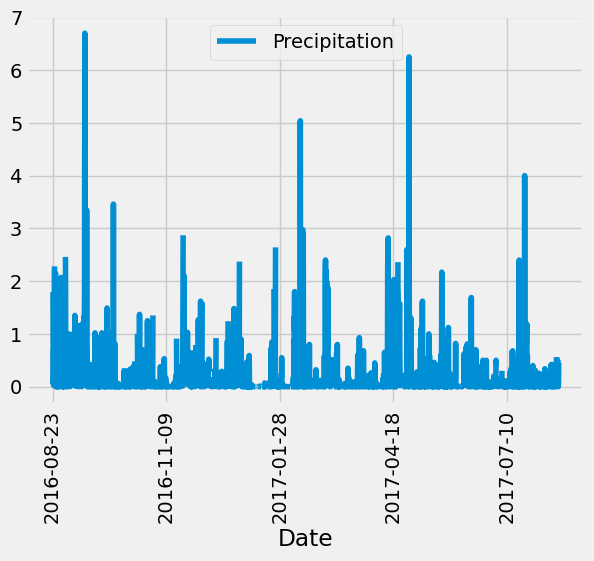

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
# Save the query results as a Pandas DataFrame. Explicitly set the column names

# Read data info DF
prcp_results_pd = pd.DataFrame(date_measurement_results, columns=['Date','Precipitation'])

# Set Date column in DF to index
prcp_results_pd = prcp_results_pd.set_index("Date")

# Sort DF by date
prcp_results_pd = prcp_results_pd.sort_values(["Date"], ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
prcp_results_pd.plot(rot=90) #from https://stackoverflow.com/questions/32244019/how-to-rotate-x-axis-tick-labels-in-a-pandas-plot
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_results_pd.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station.id).count()
total_stations

9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.id)).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Idenitfy the Station Name of the most active station 
most_active_station_name = active_stations[0][0]

# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station_name).all()
 

[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 0, 'Temperature')

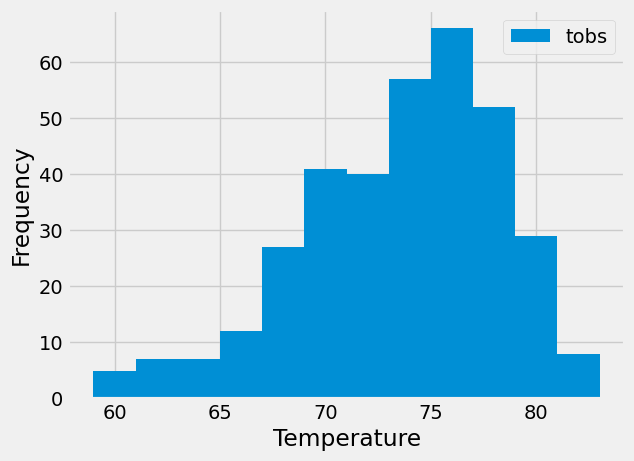

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_one_year_results = session.query(Measurement.date, Measurement.tobs).\
                                    filter(Measurement.date > one_year_before_measurement_date).\
                                    filter(Measurement.date <= recent_measurement_date).\
                                    filter(Measurement.station == most_active_station_name).all()

# convert to dataframe
most_active_one_year_results_df = pd.DataFrame(most_active_one_year_results)

# historgram 
most_active_one_year_results_df.plot.hist(bins=12,rwidth=1.0,label='tobs')
plt.ylabel('Frequency')
plt.xlabel('Temperature')




# Close Session

In [17]:
# Close Session
session.close()